In [1]:
import os, math
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append('/Users/yao/Desktop/ML/cancer/I_vote_for_cancer/yao/misc')
import helpers

%matplotlib inline
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.metrics import log_loss

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb

In [2]:
train_full = pd.read_csv('../feature_engineer/training_SeparateText.csv')
train_full = train_full.sort_values('ID').reset_index(drop=True)

//anaconda/envs/cancer/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-26 21:29:09.482347. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Use TF-IDF to Vectorize the texts， a feature selector, then SVM one-vs-all classification. 

In [24]:
##Pipeline
tfidf = TfidfVectorizer(max_features=50000, lowercase = True, analyzer='word', max_df=0.7, min_df=1)
ffilter = TruncatedSVD(n_components=1000)

##Data and labels
y = train_full["Class"]-1
X = ffilter.fit_transform(tfidf.fit_transform(train_full["SeparateText"]), y)

//anaconda/envs/cancer/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-26 22:36:08.432600. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

//anaconda/envs/cancer/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-26 22:46:04.259215. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [30]:
params = {
        'eta': 0.03333,
        'max_depth': 5,
        'min_child_weight': 1,
        'gamma': 0,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': 0,
        'silent': True
    }

watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)

//anaconda/envs/cancer/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-26 22:46:16.084346. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[0]	train-mlogloss:2.13849	valid-mlogloss:2.15428
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:0.951515	valid-mlogloss:1.33581
[100]	train-mlogloss:0.570754	valid-mlogloss:1.14063
[150]	train-mlogloss:0.385038	valid-mlogloss:1.06373
[200]	train-mlogloss:0.27171	valid-mlogloss:1.03177
[250]	train-mlogloss:0.197636	valid-mlogloss:1.02246
[300]	train-mlogloss:0.147367	valid-mlogloss:1.02315
Stopping. Best iteration:
[249]	train-mlogloss:0.198867	valid-mlogloss:1.02209



In [13]:
#Evaluate
y_test_prob = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
log_loss(y_test, y_test_prob, eps=1e-15, normalize=True, labels = list(range(9)))

0.98069759625661423

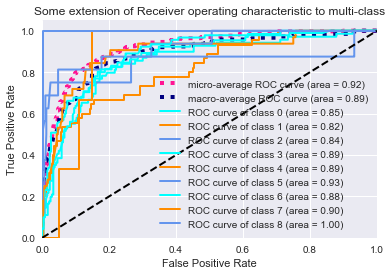

In [21]:
helpers.plot_roc_curve(y_test_bi, y_test_prob)

In [16]:
true_test_full = helpers.get_full_table('./input/test_variants','./input/test_text')
X_true_test = np.concatenate((GeneSvm().get_feature(pl1, true_test_full), TfidfSvm().get_feature(pl2, true_test_full).todense()), axis=1)

true_test_prob = model.predict(xgb.DMatrix(X_true_test), ntree_limit=model.best_ntree_limit)



this is a model based on only gene&variations
this is a tfidf+svm model


In [18]:
helpers.submission('./input/submission_xgb.csv', true_test_prob)

In [19]:
feature = GeneSvm().get_feature(pl1, true_test_full)
np.save('./2nd_layer_data/gene-var/X_true_test', feature)

this is a model based on only gene&variations
